In [175]:
import math
import numpy as np

import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

from utils import translate, pairwise_kernels

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics.pairwise import pairwise_distances

In [303]:
# constants
N_POINTS_ARR = [100, 200, 400, 800]
N_NEIGHBORS = 15
N_RUNS = 5

EPS_MEAN = 0
EPS_STD_DEV = 0.05

In [304]:
# creating true data
x = np.linspace(-1, 1, 25)
y = np.linspace(-2, 2, 50)

xx, yy = np.meshgrid(y, x)
zz = 0.3 * np.sin(2 * xx) + 0.1 * np.cos(3.5 * xx) + 0.25 * np.exp(-yy) - 0.5

In [305]:
# creating empirical data
x_arr = [[[] for i in range(N_RUNS)] for i in range(len(N_POINTS_ARR))]
y_arr = [[[] for i in range(N_RUNS)] for i in range(len(N_POINTS_ARR))]
z_arr = [[[] for i in range(N_RUNS)] for i in range(len(N_POINTS_ARR))]

for i, N_POINTS in enumerate(N_POINTS_ARR):
    for j in range(N_RUNS):
        
        x = np.random.uniform(-1, 1, N_POINTS)
        y = np.random.uniform(-2, 2, N_POINTS)
        z = 0.3 * np.sin(2 * y) + 0.1 * np.cos(3.5 * y) + 0.25 * np.exp(-x) - 0.5

        x_arr[i][j] = x
        y_arr[i][j] = y
        z_arr[i][j] = z

In [306]:
# nonparametic regression
T_x = np.linspace(-2, 2, 100)
T_y = np.linspace(-1, 1, 100)

T_xx, T_yy = np.meshgrid(T_x, T_y)

T = np.dstack((T_xx, T_yy)).reshape(-1, 2)

X_arr = [[[] for i in range(N_RUNS)] for i in range(len(N_POINTS_ARR))]
z_hat_arr = [[[] for i in range(N_RUNS)] for i in range(len(N_POINTS_ARR))]

for i, N_POINTS in enumerate(N_POINTS_ARR):
    for j in range(N_RUNS):

        X = np.dstack((y_arr[i][j], x_arr[i][j])).reshape(N_POINTS, -1)

        nonparametric_regression = KNeighborsRegressor(n_neighbors=N_NEIGHBORS)
        z_hat = nonparametric_regression.fit(X, z_arr[i][j]).predict(T)

        X_arr[i][j] = X
        z_hat_arr[i][j] = z_hat

In [307]:
# plot styling
line_marker_blue = dict(color='#0066FF', width=1)
line_marker_green = dict(color='#00CC66', width=1)
line_marker_red  = dict(color='#CC3300', width=2)
line_marker_grey  = dict(color='#333333', width=2)
marker = dict(size=2, color='#0066FF')

In [209]:
# empirical data, true and regression plot
lines = []

lines.append(go.Scatter3d(x=y_arr[0][0], y=x_arr[0][0], z=z_arr[0][0], marker=marker, mode="markers"))

for i, j, k in zip(xx, yy, zz):
    lines.append(go.Scatter3d(x=i, y=j, z=k, line=line_marker_blue, mode="lines", opacity=0.5, hoverinfo="skip"))

scene = dict(
    camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=-0.1),
        eye=dict(x=0.65, y=0.8, z=0.65)
    )
)

layout = go.Layout(
    title='Data points',
    showlegend=False,
    scene=scene
)

fig = go.Figure(data=lines, layout=layout, )
py.iplot(fig)

In [308]:
# extracting neighborhoods
neigborhoods_arr = [[[] for i in range(N_RUNS)] for i in range(len(N_POINTS_ARR))]
neigborhoods_ids_arr = [[[] for i in range(N_RUNS)] for i in range(len(N_POINTS_ARR))]
points_arr = [[[] for i in range(N_RUNS)] for i in range(len(N_POINTS_ARR))]

for i, N_POINTS in enumerate(N_POINTS_ARR):
    for j in range(N_RUNS):
        points = np.hstack((X_arr[i][j], z_arr[i][j].reshape(N_POINTS, -1)))
        nbrs = NearestNeighbors(n_neighbors=N_NEIGHBORS).fit(points)
        distances, indices = nbrs.kneighbors(points)
        neigborhoods = points[indices]
        neigborhoods_ids = indices
        #neigborhoods[0], neigborhoods_ids[0],
        #neigborhoods.shape

        points_arr[i][j] = points
        neigborhoods_arr[i][j] = neigborhoods
        neigborhoods_ids_arr[i][j] = neigborhoods_ids

In [309]:
neigborhoods_arr[0][0].shape

(100, 15, 3)

In [310]:
# create Q(X_i) matrix
D = 3 # dimensionality of ambient space
d = 2 # dimensionality of embedding space

Q_X_arr = [[[] for i in range(N_RUNS)] for i in range(len(N_POINTS_ARR))]

for i, N_POINTS in enumerate(N_POINTS_ARR):
    for j in range(N_RUNS):
        Q_X = np.zeros((N_POINTS, D, d)) # Q(X_i), N_POINTS x d x D
        Q_X_arr[i][j] = Q_X

In [311]:
Q_X_arr[0][0].shape

(100, 3, 2)

In [312]:
# estimating tangent spaces
for i, N_POINTS in enumerate(N_POINTS_ARR):
    for j in range(N_RUNS):
        for k, _ in enumerate(neigborhoods_arr[i][j]):

            neigborhood_local = translate(neigborhoods_arr[i][j][k], neigborhoods_arr[i][j][k][0])
            U, S, V = np.linalg.svd(neigborhood_local.T.dot(neigborhood_local))

            Q_X_arr[i][j][k] = V[:d].T # take first d eigenvectors

In [313]:
Q_X_arr[0][0][0]

array([[-0.80507961, -0.38977212],
       [ 0.53262868, -0.80678903],
       [ 0.26106226,  0.44403734]])

In [189]:
# tangent vectors plot
tangent_plot = []

for i, _ in enumerate(neigborhoods_arr[0][0]):
    if (i > 500): break # remove!
    
    for e, eigenvector in enumerate(Q_X_arr[0][0][i].T):
        
        tangent_vector = [[points_arr[0][0][i][0], points_arr[0][0][i][0] + eigenvector[0]],
                          [points_arr[0][0][i][1], points_arr[0][0][i][1] + eigenvector[1]],
                          [points_arr[0][0][i][2], points_arr[0][0][i][2] + eigenvector[2]]]
        
        if (e==0):
            tangent_plot.append(go.Scatter3d(x=tangent_vector[0], y=tangent_vector[1], z=tangent_vector[2],
                                            line=line_marker_red, mode="lines", opacity=0.5, hoverinfo="skip"))
            
        if (e==1):
            tangent_plot.append(go.Scatter3d(x=tangent_vector[0], y=tangent_vector[1], z=tangent_vector[2],
                                            line=line_marker_grey, mode="lines", opacity=0.5, hoverinfo="skip"))

        #print(tangent_vector)
        #print("\r")
            
lines.append(go.Scatter3d(x=y_arr[0][0], y=x_arr[0][0], z=z_arr[0][0], marker=marker, mode="markers"))

for i, j, k in zip(xx, yy, zz):
    tangent_plot.append(go.Scatter3d(x=i, y=j, z=k, line=line_marker_blue, mode="lines", opacity=0.5, hoverinfo="skip"))

scene = dict(
    camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=-0.1),
        eye=dict(x=0.65, y=0.8, z=0.65)
    )
)
            
layout = go.Layout(
    title='Tangent vectors',
    showlegend=False,
    scene=scene
)
fig = go.Figure(data=tangent_plot, layout=layout)
py.iplot(fig)

In [314]:
H_X_arr = np.copy(Q_X_arr)

3 steps:

1. Nadaraya-Watson nonparametric regression
2. Projection to original tangent plane
3. Changing vector length

$$H_i^{(k+1)} = C \cdot Q_iQ_i^T \cdot \frac{\sum_j K(X_i, X_j) \cdot H_j^{(k)}}{\sum_j K(X_i, X_j)}$$

$$H_i^{(k+1)} = P(X_i) \cdot \frac{\sum_j K(X_i, X_j) \cdot H_j^{(k)}}{\sum_j K(X_i, X_j)}$$

$$\sum_{i,j} K(X_i, X_j) \cdot \| H(X_i) - H(X_j) \|_F^2 \rightarrow \min_{H_i}$$

In [315]:
# iterative update
n_iter = 100

deltas_arr = [[[] for i in range(N_RUNS)] for i in range(len(N_POINTS_ARR))]

# initialize I_D, H_X
I_D = np.eye(D)
I_d = np.eye(d)
I_d_diag = np.vstack([I_d, np.array([0., 0.])])

#print(H_X_arr[0][0][0], np.linalg.norm(H_X_arr[0][0][0]))

H_X_arr = np.copy(Q_X_arr)
H_X_arr_next = [[[] for i in range(N_RUNS)] for i in range(len(N_POINTS_ARR))]

for n, N_POINTS in enumerate(N_POINTS_ARR):
    for m in range(N_RUNS):
        
        print("N={}, M={}".format(n, m))
        
        for k in range(n_iter): # run k iterations

            H_X_arr_next[n][m] = np.zeros((N_POINTS, D, d))

            for i in range(N_POINTS): # update N_POINTS

                neighborhood = neigborhoods_arr[n][m][i]
                j = neigborhoods_ids_arr[n][m][i][1:]

                # kernel
                K = pairwise_kernels(neighborhood)[0][1:]

                # projection to original tangent plane
                P_i = Q_X_arr[n][m][i].dot(Q_X_arr[n][m][i].T)

                H_i = (K[:,None,None] * H_X_arr[n][m][j]).sum(axis=0) / K.sum()
                H_P_ij = P_i.dot(H_i)

                U, S, V = np.linalg.svd(H_P_ij)
                
                #print(U.dot(I_d_diag).dot(V))

                H_X_arr_next[n][m][i] = U.dot(I_d_diag).dot(V)

            H_X_arr[n][m] = H_X_arr_next[n][m]

            # functional
            delta = 0
            for i in range(N_POINTS):
                #if (i > 1): break

                neighborhood = neigborhoods_arr[n][m][i]
                j = neigborhoods_ids_arr[n][m][i][1:]

                # kernel
                K = pairwise_kernels(neighborhood)[0][1:]

                H_D = H_X_arr[n][m][i] - H_X_arr[n][m][j]

                delta += (K * np.array(map(np.linalg.norm, H_D))).sum()

            #deltas.append(delta)
            
            deltas_arr[n][m].append(delta)

N=0, M=0
N=0, M=1
N=0, M=2
N=0, M=3
N=0, M=4
N=1, M=0
N=1, M=1
N=1, M=2
N=1, M=3
N=1, M=4
N=2, M=0
N=2, M=1
N=2, M=2
N=2, M=3
N=2, M=4
N=3, M=0
N=3, M=1
N=3, M=2
N=3, M=3
N=3, M=4


In [318]:
deltas_arr

[[[326.67133072301368,
   243.99048833840769,
   223.49375805781651,
   211.85526630664103,
   204.14551143598072,
   198.90093452077068,
   195.21820712852508,
   192.54635692106865,
   190.54653068125248,
   189.00933073935761,
   187.80248127241359,
   186.83968895944855,
   186.06199114019341,
   185.42744702897252,
   184.90524279975546,
   184.47217492335966,
   184.11045071083424,
   183.80624716273911,
   183.54872378814431,
   183.32931948943371,
   183.14123564112043,
   182.97904699305553,
   182.83840405328593,
   182.71580314844644,
   182.60840773001294,
   182.51390904138842,
   182.43041724743463,
   182.35637622118844,
   182.29049672780641,
   182.23170392436947,
   182.17909600693602,
   182.13191154616126,
   182.08950360449387,
   182.05131915571451,
   182.01688265861995,
   181.98578289261948,
   181.9576623609538,
   181.93220872041979,
   181.90914781515647,
   181.88823798409987,
   181.86926538321899,
   181.8520401192653,
   181.83639303508673,
   181.822173

([356.63632595631429,
  237.27829551419117,
  207.40252736455341,
  193.07722996500917,
  185.15846019234536,
  180.4176417518286,
  177.4630787274433,
  175.55735542921948,
  174.28716791228538,
  173.40727949157932,
  172.77162534188005,
  172.29355206169217,
  171.92135028617849,
  171.6235184728088,
  171.38011167961707,
  171.17788341776554,
  171.00761024263375,
  170.86260530720239,
  170.73786686637376,
  170.62956741129705,
  170.53473010425805,
  170.45101248418388,
  170.37655490909341,
  170.30987037070523,
  170.24976223199445,
  170.19526169314614,
  170.14557968512355,
  170.10006956948206,
  170.05819805977779,
  170.0195224609061,
  169.98367279467109,
  169.95033772052858,
  169.91925341319322,
  169.89019474967102,
  169.86296830397606,
  169.83740675975019,
  169.8133644373921,
  169.79071369915022,
  169.76934204746127,
  169.749149772066,
  169.73004803273855,
  169.7119572888339,
  169.69480600586212,
  169.67852958412831,
  169.66306946606323,
  169.648372387942

In [317]:
deltas_np_arr = np.array(deltas_arr)
y = list(deltas_np_arr[:,:,-1].flatten())
x = N_POINTS_ARR
x, y

([100, 200, 400, 800],
 [181.67755522370695,
  170.02557839312473,
  156.89044947529476,
  158.12829542085666,
  180.03928739033876,
  307.30881059010881,
  304.55968980784081,
  286.69338825419965,
  292.50754277311796,
  292.71606844022392,
  468.88058768807122,
  471.76507844631595,
  482.90722747694912,
  485.95908244058086,
  482.53968826522231,
  769.13290606371334,
  736.36894821081114,
  784.79382271365068,
  759.08256112931133,
  730.43143594153264])

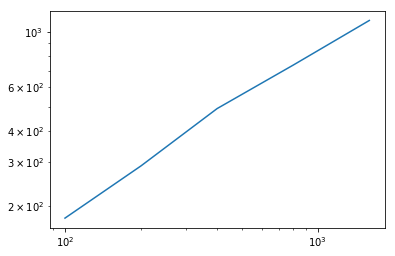

In [302]:
plt.plot(x, y)
plt.xscale('log')
plt.yscale('log')
plt.show()

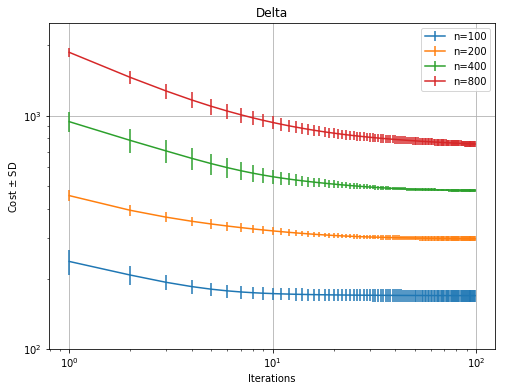

In [371]:
captions = []
plt.figure(figsize=(8, 6))

for i, N_POINTS in enumerate(N_POINTS_ARR):
    deltas_np_arr = np.array(deltas_arr[i])
    mean = list(deltas_np_arr.mean(axis=0))
    std = list(deltas_np_arr.std(axis=0))
    x = range(len(std))
    #mean, std
    
    cap = plt.errorbar(x, mean, yerr=std, label=("n=" + str(N_POINTS)))
    captions.append(cap)

#plt.errorbar(x, mean, yerr=std)
#plt.xscale('log')
#plt.yscale('log')

# visualize transitions
plt.legend(handles=captions)
plt.title('Delta', fontdict={'size': 12 })
plt.ylabel('Cost $\pm$ SD')
plt.xlabel('Iterations')
plt.xscale('log')
plt.yscale('log')
plt.ylim([100, 2500])
plt.grid()
plt.show()

In [247]:
%matplotlib inline
import seaborn as sns

#plt.errorbar(deltas_np_arr)
#plt.yscale('log')
#plt.xscale('log')
#plt.show()

ax = sns.tsplot(data=deltas_np_arr, err_style="ci_bars")
ax.set_xscale('log')
ax

ValueError: cannot convert float NaN to integer

In [197]:
# tangent vectors plot
tangent_plot = []

for i, _ in enumerate(neigborhoods_arr[0][0]):
    if (i > 500): break # remove!
    
    for e, eigenvector in enumerate(H_X_arr[0][0][i].T):
        
        tangent_vector = [[points_arr[0][0][i][0], points_arr[0][0][i][0] + eigenvector[0]],
                          [points_arr[0][0][i][1], points_arr[0][0][i][1] + eigenvector[1]],
                          [points_arr[0][0][i][2], points_arr[0][0][i][2] + eigenvector[2]]]

        if (e==0):
            tangent_plot.append(go.Scatter3d(x=tangent_vector[0], y=tangent_vector[1], z=tangent_vector[2],
                                            line=line_marker_red, mode="lines", opacity=0.5, hoverinfo="skip"))
        if (e==1):
            tangent_plot.append(go.Scatter3d(x=tangent_vector[0], y=tangent_vector[1], z=tangent_vector[2],
                                            line=line_marker_grey, mode="lines", opacity=0.5, hoverinfo="skip"))

        #print(tangent_vector)
        #print("\r")
            
tangent_plot.append(go.Scatter3d(x=y_arr[0][0], y=x_arr[0][0], z=z_arr[0][0], marker=marker, mode="markers"))

for i, j, k in zip(xx, yy, zz):
    tangent_plot.append(go.Scatter3d(x=i, y=j, z=k, line=line_marker_blue, mode="lines", opacity=0.5, hoverinfo="skip"))
            
layout = go.Layout(
    title='Tangent vectors',
    showlegend=False,
)
fig = go.Figure(data=tangent_plot, layout=layout)
py.iplot(fig)